In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from seisfwi.model import ElasticModel
from seisfwi.survey import Survey, Source, Receiver, GenericCable
from seisfwi.propagator import ElasticPropagator
from seisfwi.utils import wavelet, moment_tensor

from seisfwi.view import plot_data

### Parameters for elastic model

In [3]:
ox = 0.0
oz = 0.0
nx = 201
nz = 101
dx = 10.0
dz = 10.0

nt = 601
dt = 0.001
f0 = 20.0
amp = 1e7

vp = np.ones((nz, nx), dtype=np.float32) * 4500.0
vs = vp / 1.732
rho = np.power(vp, 0.25) * 310

# Create a elastic model object
model = ElasticModel(ox, oz, dx, dz, nx, nz, vp = vp, vs = vs,rho = rho, free_surface=True, nabc=20)

model

Elastic model with parameters ['vp', 'vs', 'rho']:
  Model vp  :  4500.00 -  4500.00 m/s   , requires_grad = False, constrain bound: None - None
  Model vs  :  2598.15 -  2598.15 m/s   , requires_grad = False, constrain bound: None - None
  Model rho :  2539.01 -  2539.01 kg/m^3, requires_grad = False, constrain bound: None - None
  Model orig: ox =   0.00, oz =   0.00 m
  Model grid: dx =  10.00, dz =  10.00 m
  Model dims: nx =    201, nz =    101
  Model size: 60903
  Free surface: True
  Absorbing layers: 20

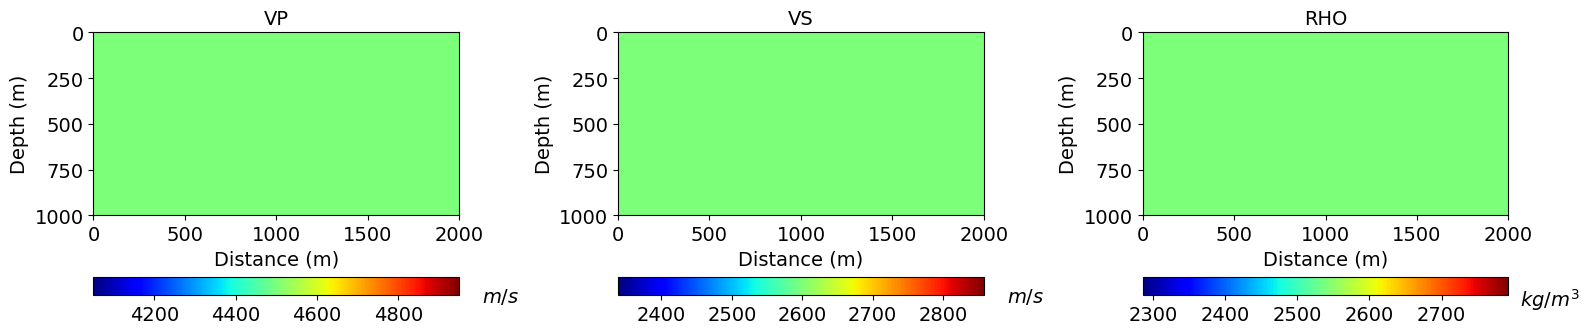

In [4]:
model.plot()

### Seismic Source 

In [5]:
# Create a seismic sources
source = Source(nt = nt, dt = dt, f0 = f0)

# Create wavelet
wvlt = wavelet(nt, dt, f0) * amp

# Set source attributes
source.add_source([1000, 20.0], wvlt, 'pr')

### Test on Straignt Cable

In [6]:
import numpy as np
import math

# set the straight line
angle = 45   # Test on 0, 45, 90
x0 = 200.0
z0 = 200.0
d = 500.0

# set trajectory
dx0, dz0 = d * np.cos(angle*np.pi/180), d * np.sin(angle*np.pi/180)
traj = np.array([[x0, 0.0, z0], [x0 + dx0, 0.0, z0 + dz0], [x0 + 2 * dx0, 0.0, z0 + 2*dz0]])

# set the cable
chann_len = 10.0
chann_num = 99
gauge_len = 10.0

cable = GenericCable(traj, chann_len, chann_num, gauge_len)
cable

DAS Cable Information: 
  Cable total length: 1000.00 m 
  Channel coverage: 5.00 - 995.00 m 
  Channel interval: 10.00 m 
  Channel number: 99 
  Gauge length: 10.00 m 
  Max channel length error: 0.0001 m 
  Max  gauge  length error: 0.0001 m 


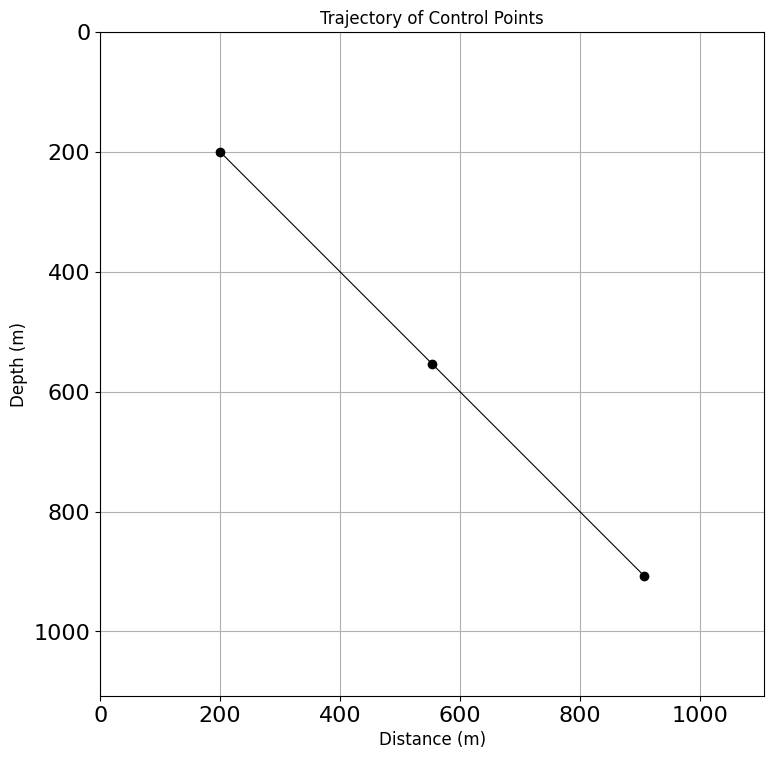

In [16]:
# plot provided trajectory
cable.plot_traj(save_path='benchmark-model.png')

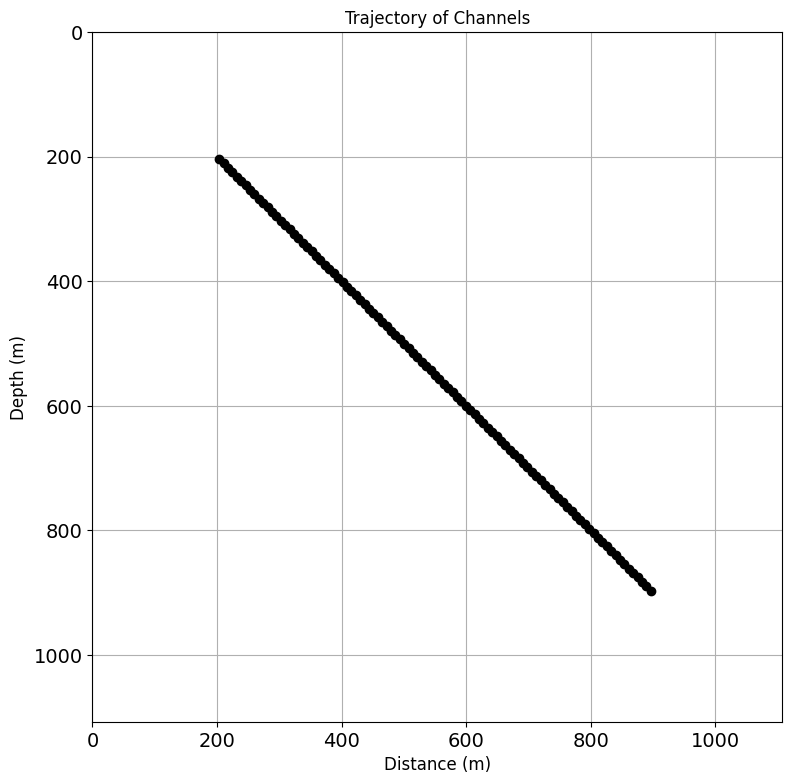

In [8]:
# plot channel location
cable.plot_channel()

### Set Receiver, Survey, and Modeling

In [9]:
# Create a set of seismic receiver
receiver = Receiver(nt = nt, dt = dt)

receiver.add_cable(cable)

geo_coords = cable.get_rec_loc()

for irec in range(geo_coords.shape[0]):
    x = geo_coords[irec][0]
    z = geo_coords[irec][2]
    receiver.add_receiver([x, z], 'vx')
    receiver.add_receiver([x, z], 'vz')

# Note: for DAS modeling, we have to set interpolation to be True
survey = Survey(source=source, receiver=receiver, device='cpu', reciprocity=False, simultaneous=False, interpolation=True)


  DAS cable is added to the survey with 100 unique receivers


In [10]:
F = ElasticPropagator(model, survey)
data = F()

Survey analysis completed: legal survey
free surface: True


### Benchmark on DAS data

In [11]:
# Modeled DAS data to be benchmarked
test_das = data.get_data(shotid=0, comp='das')

# Compute the true DAS data
true_vx = data.get_data(shotid=0, comp='vx')
true_vz = data.get_data(shotid=0, comp='vz')
nrec = true_vx.shape[0]

indices1 = np.arange(0, nrec, 2)
indices2 = np.arange(1, nrec, 2)

# d(s) = (Vz(s+gl/2) - Vz(s+gl/2)/gl
f1 = np.cos(angle * np.pi/180)
f2 = np.sin(angle * np.pi/180)

true_das = f1 * (true_vx[indices2,:] - true_vx[indices1,:]) / gauge_len + \
           f2 * (true_vz[indices2,:] - true_vz[indices1,:]) / gauge_len


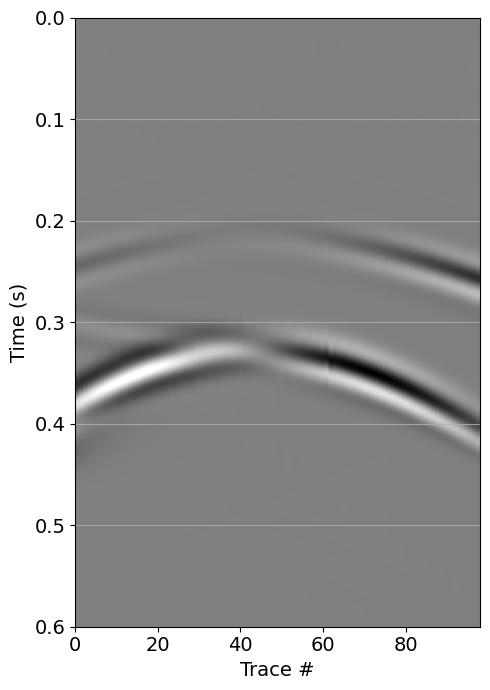

In [12]:
# compare DAS data
plot_data(test_das, dt=dt, figsize=(5, 7))

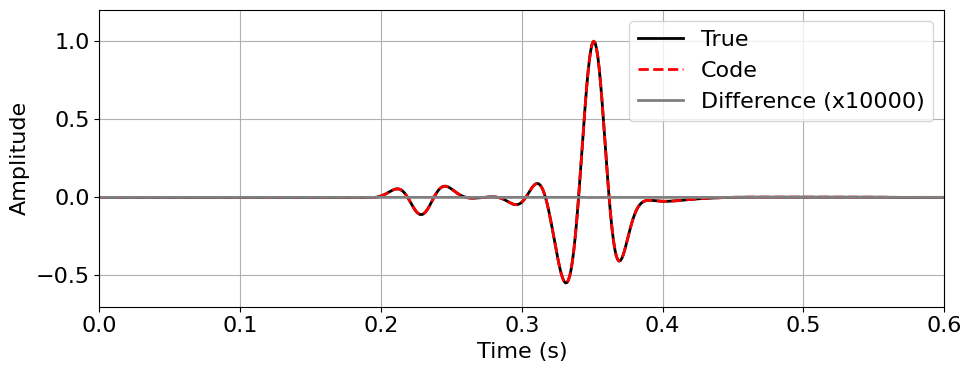

In [14]:
font_size = 16
params = {
    'image.cmap': 'seismic',
    'axes.grid': False,
    'savefig.dpi': 300,
    'font.size': font_size,
    'axes.labelsize': font_size,
    'legend.fontsize': font_size,
    'xtick.labelsize': font_size,
    'ytick.labelsize': font_size,
}

plt.rcParams.update(params)

irec = 15
test_trace = test_das[irec,:]/np.max(abs(test_das[irec,:]))
true_trace = true_das[irec,:]/np.max(abs(true_das[irec,:]))

plt.figure(figsize=(10, 4))
plt.plot(data.t, true_trace, 'k-', label='True', linewidth=2)
plt.plot(data.t, test_trace, 'r--',label='Code', linewidth=2)
plt.plot(data.t, (true_trace-test_trace)*10000, '-',color='gray', label='Difference (x10000)', linewidth=2)
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.grid()
plt.xlim([0.0, 0.6])
plt.ylim([-0.7, 1.2])
plt.legend()
plt.tight_layout()
plt.savefig('benchmark-data.png', dpi=300)